# Settings

In [1]:
import torch
from src.model.clip import load
from src.model.model import IM2TEXT
from src.third_party.open_clip.clip import _transform, tokenize
from src.utils import convert_models_to_fp32

from src.dataset import CIRR, CIRRImageSplit
from torch.utils.data import DataLoader
import faiss
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [2]:
def show_images(img_list):  # list(tuple(image, title))
    num_img = len(img_list)
    figsize = num_img * 10

    plt.figure(figsize=(figsize, figsize))

    for i in range(num_img):
        img, title = img_list[i]

        plt.subplot(1, num_img, i + 1)
        plt.title(title)

        # Convert pil image to numpy array
        img = np.array(img)

        # Resize the image to a fixed size
        img = cv.resize(img, (300, 300))

        # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        cmap = None if len(img.shape) == 3 else "gray"
        img = plt.imshow(img, cmap, interpolation="bicubic")
        plt.axis("off")

In [3]:
ckpt_path = "checkpoints\pic2word_model.pt"

checkpoint = torch.load(ckpt_path)

# CLIP Model

In [4]:
clip_model, preprocess_train, preprocess_val = load(name="ViT-L/14", jit=False)

In [5]:
convert_models_to_fp32(clip_model)

In [6]:
clip_model = clip_model.cuda()

clip_sd = checkpoint["state_dict"]
clip_sd = {k[len("module.") :]: v for k, v in clip_sd.items()}  # strip the names
clip_model.load_state_dict(clip_sd)

<All keys matched successfully>

# Mapping Network

In [7]:
img2text = IM2TEXT(
    embed_dim=clip_model.embed_dim,
    output_dim=clip_model.token_embedding.weight.shape[1],
)

In [8]:
img2text = img2text.cuda()

i2t_sd = checkpoint["state_dict_img2text"]
i2t_sd = {
    k[len("module.") :]: v for k, v in i2t_sd.items()
}  # strip the names
img2text.load_state_dict(i2t_sd)

<All keys matched successfully>

# Dataset


In [9]:
cirr = CIRR(transforms=preprocess_val, root="./data", mode="caps", vis_mode=True)

Loading json data from ./data\CIRR\captions/cap.rc2.val.json
Use 2206 imgs


In [10]:
dl = DataLoader(
    cirr,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

len(dl)

2206

In [11]:
batch, label = next(iter(dl))

In [12]:
batch.shape, len(label)

(torch.Size([1, 3, 224, 224]), 1)

In [13]:
# this dataset is used for collection indexing
cirr_image_split = CIRRImageSplit(
    transforms=preprocess_val, root="./data", split="test"
)

Loading json data from data\CIRR\image_splits\split.rc2.test1.json
Use 2315 imgs


In [14]:
split_dl = DataLoader(
    cirr_image_split,
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

len(split_dl)

290

In [15]:
img_batch, img_key = next(iter(split_dl))

img_batch.shape, len(img_key)

(torch.Size([8, 3, 224, 224]), 8)

# Dummy inference

In [16]:
# encode image 

with torch.no_grad():
    image_features = clip_model.encode_image(batch.cuda())

print(image_features.shape)

torch.Size([1, 768])


In [17]:
# map visual features to text features

with torch.no_grad():
    query_img_feat = img2text(image_features)

print(query_img_feat.shape)

torch.Size([1, 768])


In [18]:
# tokenize the prompt

def process_prompt(prompt):
    text = []

    for p in prompt:
        text_tokens = tokenize(p)
        text.append(text_tokens)
    text = torch.cat(text, dim=0)
    return text

In [19]:
text = "A photo of * with a caption of a bird."

text = process_prompt([text])

text = text.cuda()

text.shape

torch.Size([1, 77])

In [20]:
# compose text with visual features
split_id = tokenize(["*"])[0][1]

with torch.no_grad():
    composed_feature = clip_model.encode_text_img_vis(
        text, query_img_feat, split_ind=split_id
    )

In [21]:
composed_feature.shape

torch.Size([1, 768])

# Collection Indexing

In [22]:
def normalize(x):
    return x / x.norm(dim=-1, keepdim=True)

In [23]:
# Create a IP index
# index = faiss.IndexFlatIP(clip_model.embed_dim)

In [24]:
# Indexing
# with tqdm(total=len(split_dl)) as pbar:
#     for batch, key in split_dl:
#         with torch.no_grad():
#             image_features = clip_model.encode_image(batch.cuda())
#             image_features = normalize(image_features)
#             index.add(image_features.cpu().numpy())
#         pbar.update(1)

# write index to disk
# faiss.write_index(index, 'data/indexes/cirr_test.IP.index')

In [26]:
# read index from disk
index = faiss.read_index("data/indexes/cirr_test.IP.index")

In [27]:
# number of indexed vectors
index.ntotal

2315

# Retrieval

In [28]:
def retrieve(ref_img, caption, top_k=5):
    img = preprocess_val(ref_img).unsqueeze(0)
    text = process_prompt([caption])

    img, text = img.cuda(), text.cuda()

    with torch.no_grad():
        image_features = clip_model.encode_image(img)
        query_img_feat = img2text(image_features)
        composed_feature = clip_model.encode_text_img(
            text, query_img_feat
        )
        composed_feature = normalize(composed_feature)
        D, I = index.search(composed_feature.cpu().numpy(), top_k)

    return I[0], D[0]

In [29]:
view_ds = CIRRImageSplit(transforms=None, root="./data", split="test")

Loading json data from data\CIRR\image_splits\split.rc2.test1.json
Use 2315 imgs


In [48]:
caption = "A photo of *, shows two dogs eating."

ref_img_path = "data/CIRR/img_raw/test1/test1-83-1-img1.png"

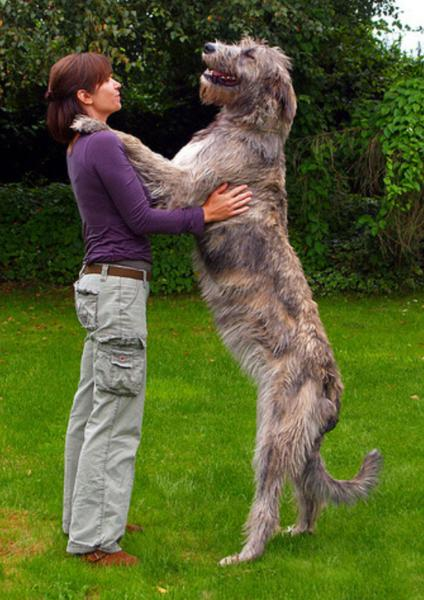

In [49]:
ref_img = Image.open(ref_img_path, mode="r")

ref_img

In [50]:
result_idx, _ = retrieve(ref_img, caption, top_k=10)

result_idx

array([   1,    3, 2226,    0,  248,    2, 1232, 2234,  922,  724],
      dtype=int64)

In [51]:
result_imgs = [view_ds[idx][0] for idx in result_idx]

result_imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=867x1150>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=424x600>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1133x756>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=393x260>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=855x575>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=517x334>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=787x625>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x423>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=825x510>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x344>]

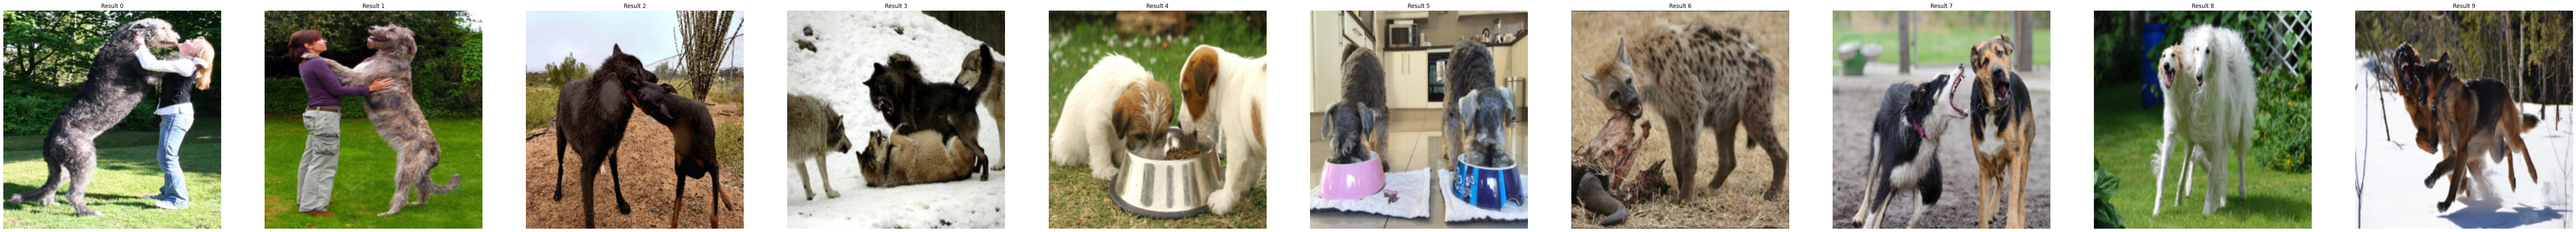

In [52]:
shown_imgs = []

for i, ref_img in enumerate(result_imgs):
    shown_imgs.append((ref_img, f"Result {i}"))

show_images(shown_imgs)